In [1]:
from twoRegionSim import twoRegionMultiInput
from src.dataHandling import loadData, makeVoltageDF,makeRateDF,makeInputDF,saveData
from plotting.plotAcrossTime import plotConstantInputAcrossTime,plotVoltageAcrossTime,plotRateAcrossTime
from plotting.plotAcrossInput import plotAverageVoltageAcrossInput,plotStdVoltageAcrossInput,splitFrameAcrossInput
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [86]:
def findEqualRatesR2(r1EToR2E=np.linspace(.5,1.5,11),r1EToR2I=np.linspace(.5,1.5,11),r1InputAmplitudes=[np.linspace(0,20,21)],r2InputAmplitudes=[np.zeros(21)],
                     repeat=5,timeLength=2500,divisions=25000):
    inputIndexes = list(range(len(r1InputAmplitudes)))
    simProduct = list(itertools.product(r1EToR2E,r1EToR2I,inputIndexes))*repeat
    feedforwardProduct = list(enumerate(simProduct))
    saveData(feedforwardProduct,'./twoRegion/data/feedforward/indexer.pkl')
    for index,paramTuple in tqdm(feedforwardProduct):
        r1EToR2EWeight = paramTuple[0]
        r1EToR2IWeight = paramTuple[1]
        inputIndex = paramTuple[2]
        twoRegionMultiInput(r1EToR2EWeight=r1EToR2EWeight,
                            r1EToR2IWeight=r1EToR2IWeight,
                            r1IToR2EWeight=0,r1IToR2IWeight=0,
                            r2EToR1EWeight=0,r2EToR1IWeight=0,r2IToR1EWeight=0,r2IToR1IWeight=0,
                            eulerTimeEnd=timeLength,divisions=divisions,r1InputAmplitudes=r1InputAmplitudes[inputIndex],
                            r2InputAmplitudes = r2InputAmplitudes[inputIndex],
                            saveName=f'feedforward/feedforwardSim{index}',progressBar=False)
findEqualRatesR2()

  0%|          | 0/605 [00:00<?, ?it/s]

In [74]:
def getFileNamesWithinStimulus(folder,fileFunction):
    indexer = loadData(f'{folder}/indexer.pkl')
    params = [label[1] for label in indexer]
    
    uniqueParams = list(set(params))
    outDict = {}
    for uniqueParam in uniqueParams:
        outDict[uniqueParam] = [f'{folder}/{fileFunction(param[0])}' for param in indexer if param[1] == uniqueParam]
    return outDict

def feedforwardFileFunc(index):
    return f'feedforwardSim{index}.pkl'

def averageFrameWithinStimuli(fileDict,frameTransform):
    paramDict = {}
    for (param,fnames) in fileDict.items():
        rateDFs = sum([frameTransform(loadData(fname)) for fname in fnames])/len(fnames)
        if not rateDFs.isnull().values.any():
            paramDict[param] = rateDFs
    return paramDict

fileDict = getFileNamesWithinStimulus('./twoRegion/data/feedforward',feedforwardFileFunc)
averageRateDFs = averageFrameWithinStimuli(fileDict,makeRateDF)
regionDifference = {key:pd.DataFrame([value['r1E']-value['r2E'],value['r1I']-value['r2I']],index=['e','i']).T for key,value in averageRateDFs.items()}
rateDistance = {key:np.sqrt(np.square(value.values).mean()) for key,value in regionDifference.items()}
minDistanceInput = min(rateDistance,key=rateDistance.get)
minDistanceR1EToR2E = minDistanceInput[0]
minDistanceR1EToR2I = minDistanceInput[1]
print(minDistanceR1EToR2E)
print(minDistanceR1EToR2I)

0.8777777777777778
0.8777777777777778


In [81]:
twoRegionMultiInput(saveName="twoRegionThreeInput",r1InputAmplitudes=[0,2,15],
                    r2InputAmplitudes=[0,0,0],
                    r1EToR2EWeight=1.2,r1EToR2IWeight=1.2,r1IToR2EWeight=0,r1IToR2IWeight=0,
                    r2EToR1EWeight=0,r2EToR1IWeight=0,r2IToR1EWeight=0,r2IToR1IWeight=0,
                    eulerTimeEnd=7500,divisions=75000)
twoRegionMultiInput(saveName='twoRegionManyInput',r1InputAmplitudes=np.linspace(0,20,21),
                    r2InputAmplitudes=np.zeros(21),
                    r1EToR2EWeight=1.2,r1EToR2IWeight=1.2,r1IToR2EWeight=0,r1IToR2IWeight=0,
                    r2EToR1EWeight=0,r2EToR1IWeight=0,r2IToR1EWeight=0,r2IToR1IWeight=0,
                    eulerTimeEnd=10000,divisions=100000)
threeStimDataset = loadData("./twoRegion/data/twoRegionThreeInput.pkl")
#simulationVoltages = threeStimDataset['voltages']
#print(simulationVoltages.mean(axis=1))
#print(simulationVoltages.std(axis=1))
threeStimVoltage = makeVoltageDF(threeStimDataset)
threeStimRate = makeRateDF(threeStimDataset)
threeStimInput = makeInputDF(threeStimDataset)
manyStimDataset = loadData("./twoRegion/data/twoRegionManyInput.pkl")
simulationVoltages = manyStimDataset['voltages']
print(simulationVoltages.mean(axis=1))
print(simulationVoltages.std(axis=1))
manyStimVoltage = makeVoltageDF(manyStimDataset)
manyStimRate = makeRateDF(manyStimDataset)
manyStimInput = makeInputDF(manyStimDataset)
plotColorMapping = {'r1E':'red','r1I':'blue','r2E':'orange','r2I':'purple','r1EInput':'black'}


[-64.80122501 -61.5630109  -64.58344949 -61.04311753]
[1.68250379 3.29818727 1.70236389 3.01462915]


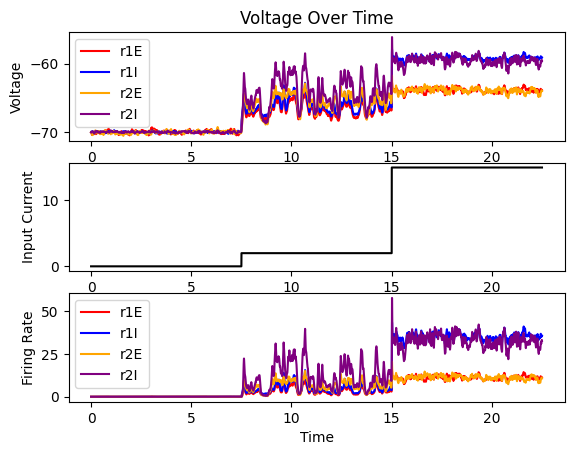

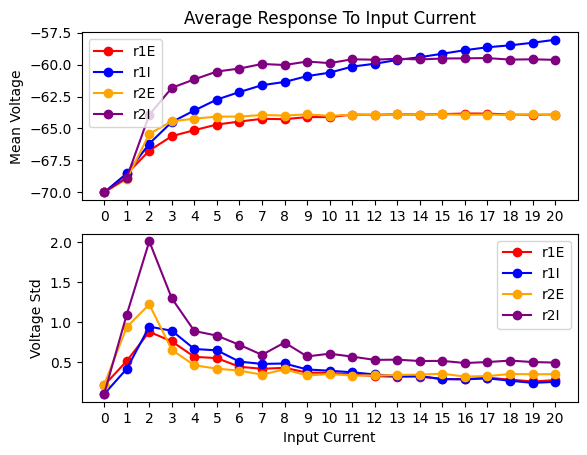

In [82]:
fig,axs = plt.subplots(3,1)
plotVoltageAcrossTime(threeStimVoltage,axs[0],plotColorMapping,xlabel="")
plotConstantInputAcrossTime(threeStimInput,'r1EInput',axs[1],plotColorMapping,xlabel="",title='')
plotRateAcrossTime(threeStimRate,axs[2],plotColorMapping,xlabel="Time",title='')

fig,axs = plt.subplots(2,1)
plotAverageVoltageAcrossInput(manyStimVoltage,manyStimInput,axs[0],plotColorMapping,'r1EInput',xlabel="",title='Average Response To Input Current')
plotStdVoltageAcrossInput(manyStimVoltage,manyStimInput,axs[1],plotColorMapping,'r1EInput',xlabel='Input Current',title='')